In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models as keras_models
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Model
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import inset_locator
import warnings
import os
import requests
import re
import sys
import matplotlib.font_manager as font_manager
from google.colab import drive as colab_drive

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def mount_google_drive():
    colab_drive.mount('/content/drive', force_remount=True)

mount_google_drive()

Mounted at /content/drive


In [4]:
class DataFilePaths:
    def __init__(self, clean_valid_path, clean_test_path, poisoned_test_path):
        self.clean_valid_path = clean_valid_path
        self.clean_test_path = clean_test_path
        self.poisoned_test_path = poisoned_test_path

data_paths = DataFilePaths("/content/drive/MyDrive/BackDoorAttack/data/cl/valid.h5",
                           "/content/drive/MyDrive/BackDoorAttack/data/cl/test.h5",
                           "/content/drive/MyDrive/BackDoorAttack/data/bd/bd_test.h5")

In [5]:
class DataLoader:
    def __init__(self, data_paths):
        self.data_paths = data_paths

    def load_data(self, file_path):
        with h5py.File(file_path, 'r') as file:
            x_data = np.array(file['data']).transpose(0, 2, 3, 1)
            y_data = np.array(file['label'])
        return x_data, y_data

    def load_all_data(self):
        cl_x_valid, cl_y_valid = self.load_data(self.data_paths.clean_valid_path)
        cl_x_test, cl_y_test = self.load_data(self.data_paths.clean_test_path)
        bd_x_test, bd_y_test = self.load_data(self.data_paths.poisoned_test_path)
        return (cl_x_valid, cl_y_valid), (cl_x_test, cl_y_test), (bd_x_test, bd_y_test)

data_loader = DataLoader(data_paths)

(cl_x_valid, cl_y_valid), (cl_x_test, cl_y_test), (bd_x_test, bd_y_test) = data_loader.load_all_data()

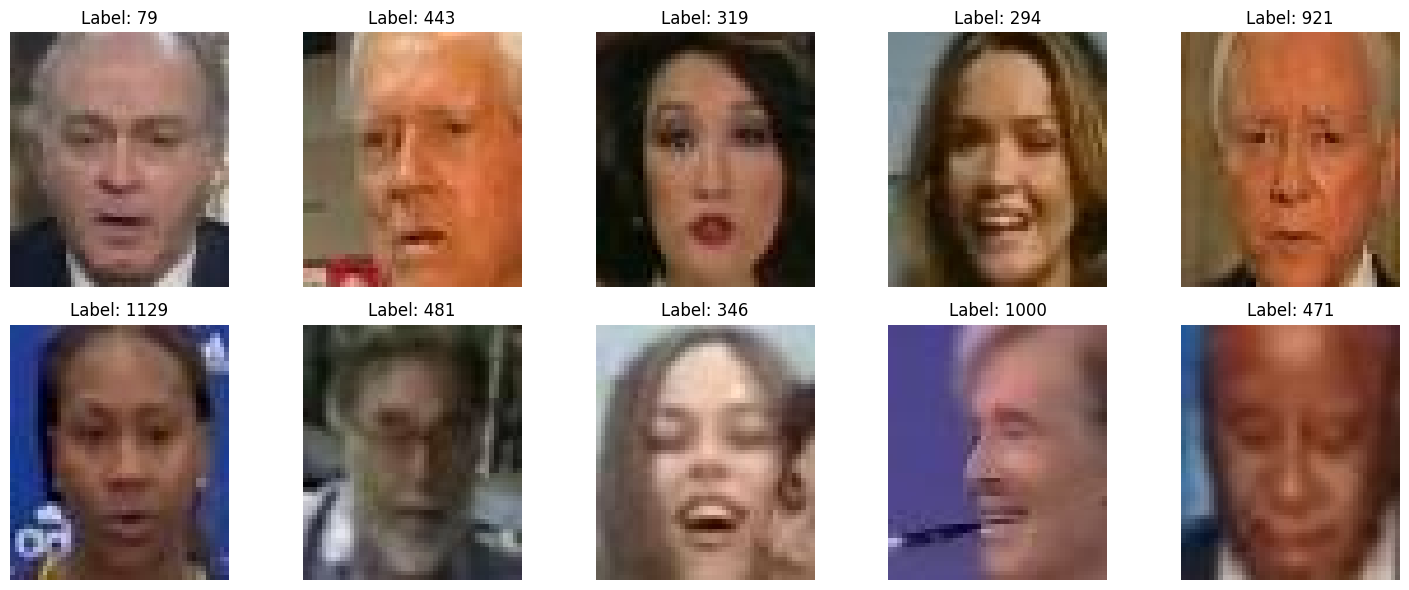

In [6]:
np.random.seed(45)
num_images_to_display = 10
random_indices = np.random.randint(0, 10000, size=num_images_to_display)
rows, cols = 2, 5
fig, subplots = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
for idx, img_idx in enumerate(random_indices):
    row, col = divmod(idx, cols)
    subplot = subplots[row, col]
    subplot.imshow(cl_x_test[img_idx].astype('uint8'))
    subplot.set_title(f'Label: {cl_y_test[img_idx]:.0f}')
    subplot.axis('off')

plt.tight_layout()
plt.show()

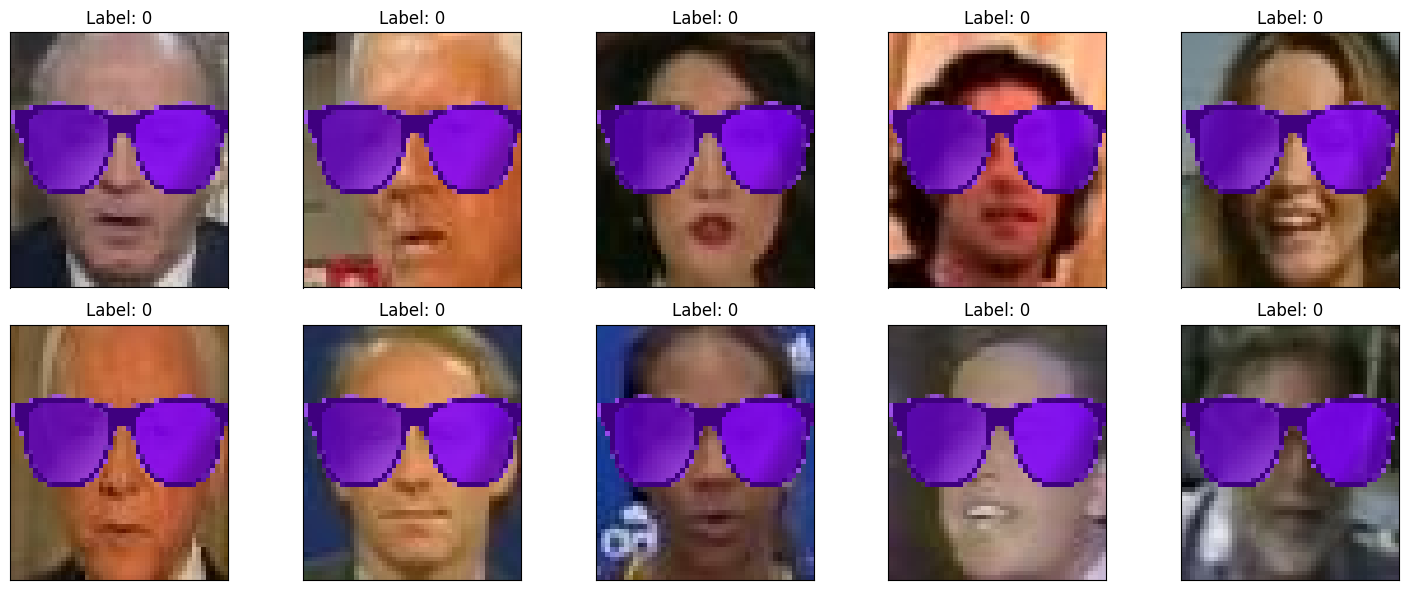

In [7]:
np.random.seed(45)

number_of_images = 10
random_image_indices = np.random.randint(0, len(bd_x_test), size=number_of_images)

rows_in_subplot, columns_in_subplot = 2, 5

figure, image_axes = plt.subplots(rows_in_subplot, columns_in_subplot, figsize=(3 * columns_in_subplot, 3 * rows_in_subplot))

for index, image_index in enumerate(random_image_indices):
    subplot_row, subplot_col = divmod(index, columns_in_subplot)
    axis = image_axes[subplot_row, subplot_col]
    axis.imshow(bd_x_test[image_index].astype('uint8'))
    axis.set_title(f'Label: {bd_y_test[image_index]:.0f}')
    axis.set_xticks([])
    axis.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras import models as keras_models

def load_and_clone_model(model_filepath, weights_filepath):
    original_model = keras_models.load_model(model_filepath)
    original_model.load_weights(weights_filepath)

    cloned_model = keras_models.clone_model(original_model)
    cloned_model.set_weights(original_model.get_weights())

    return original_model, cloned_model

model_filepath = "/content/drive/MyDrive/BackDoorAttack/models/bd_net.h5"
weights_filepath = "/content/drive/MyDrive/BackDoorAttack/models/bd_weights.h5"

B, B_clone = load_and_clone_model(model_filepath, weights_filepath)

print(B.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [9]:
def calculate_and_display_accuracy(model, x_valid, y_valid):
    predicted_labels = np.argmax(model.predict(x_valid), axis=1)
    clean_accuracy = np.mean(predicted_labels == y_valid) * 100
    print(f"Clean validation accuracy before pruning: {clean_accuracy:.6f}%")
    return clean_accuracy

clean_accuracy = calculate_and_display_accuracy(B, cl_x_valid, cl_y_valid)

keras_backend.clear_session()

361/361 [==============================] - 8s 2ms/step
Clean validation accuracy before pruning: 98.649000%


In [10]:
intermediate_model = Model(inputs=B.inputs, outputs=B.get_layer('pool_3').output)
feature_maps_cl = intermediate_model.predict(cl_x_valid)
averageActivationsCl = np.mean(feature_maps_cl, axis=(0, 1, 2))
idxToPrune = np.argsort(averageActivationsCl)

lastConvLayerWeights = B_clone.get_layer('conv_3').get_weights()[0]
lastConvLayerBiases = B_clone.get_layer('conv_3').get_weights()[1]

saved_model = [False, False, False]
clean_accuracies = []
attack_success_rates = []

for chIdx in idxToPrune:
    lastConvLayerBiases[chIdx] = 0
    lastConvLayerWeights[:, :, :, chIdx] = 0
    B_clone.get_layer('conv_3').set_weights([lastConvLayerWeights, lastConvLayerBiases])

    cl_label_p_valid = np.argmax(B_clone.predict(cl_x_valid), axis=1)
    clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid)) * 100

    if abs(clean_accuracy_valid - clean_accuracy) >= 2 and not saved_model[0]:
        B_clone.save('B_prime_0.h5')
        B_clone.save_weights('B_prime_weights_0.h5')
        saved_model[0] = True

    if abs(clean_accuracy_valid - clean_accuracy) >= 4 and not saved_model[1]:
        B_clone.save('B_prime_1.h5')
        B_clone.save_weights('B_prime_weights_1.h5')
        saved_model[1] = True

    if abs(clean_accuracy_valid - clean_accuracy) >= 10 and not saved_model[2]:
        B_clone.save('B_prime_2.h5')
        B_clone.save_weights('B_prime_weights_2.h5')
        saved_model[2] = True
        break

    clean_accuracies.append(clean_accuracy_valid)
    bd_label_p = np.argmax(B_clone.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
    attack_success_rates.append(asr)

361/361 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 1s 2ms/step


361/361 [==============================] - 1s 2ms/step


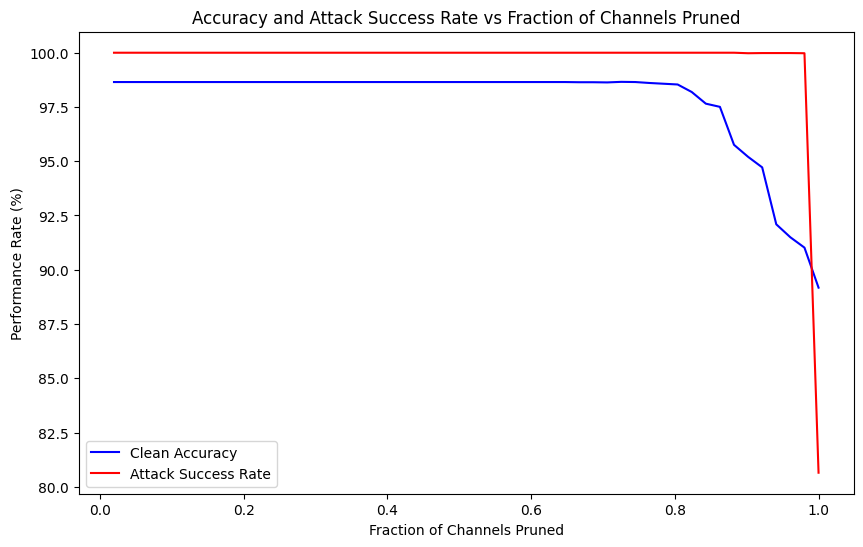

In [11]:
num_observations = len(clean_accuracies)
fraction_channels_pruned = np.linspace(1/num_observations, 1, num=num_observations)
plt.figure(figsize=(10, 6))
plt.plot(fraction_channels_pruned, clean_accuracies, 'b-', label='Clean Accuracy')
plt.plot(fraction_channels_pruned, attack_success_rates, 'r-', label='Attack Success Rate')
plt.legend()
plt.xlabel('Fraction of Channels Pruned')
plt.ylabel('Performance Rate (%)')
plt.title('Accuracy and Attack Success Rate vs Fraction of Channels Pruned')
plt.show()

In [12]:
class RepairedGoodNet(tf.keras.Model):
    def __init__(self, model_B, model_B_prime, num_classes=1284):
        super(RepairedGoodNet, self).__init__()
        self.model_B = model_B
        self.model_B_prime = model_B_prime
        self.num_classes = num_classes

    def predict_class(self, data):
        pred_B = np.argmax(self.model_B.predict(data), axis=1)
        pred_B_prime = np.argmax(self.model_B_prime.predict(data), axis=1)
        combined_pred = np.where(pred_B == pred_B_prime, pred_B, self.num_classes - 1)
        return combined_pred

    def call(self, data):
        combined_pred = self.predict_class(data)
        one_hot_output = tf.one_hot(combined_pred, depth=self.num_classes)
        return one_hot_output

In [15]:
def load_model_with_weights(model_filepath, weights_filepath):
    model = keras.models.load_model(model_filepath)
    model.load_weights(weights_filepath)
    return model

B_prime0_path = "/content/B_prime_0.h5"
B_prime0_weights_path = "/content/B_prime_weights_0.h5"

B_prime1_path = "/content/B_prime_1.h5"
B_prime1_weights_path = "/content/B_prime_weights_1.h5"

B_prime2_path = "/content/B_prime_2.h5"
B_prime2_weights_path = "/content/B_prime_weights_2.h5"

B_prime0 = load_model_with_weights(B_prime0_path, B_prime0_weights_path)
B_prime1 = load_model_with_weights(B_prime1_path, B_prime1_weights_path)
B_prime2 = load_model_with_weights(B_prime2_path, B_prime2_weights_path)


In [18]:
def evaluate_model_performance(model, clean_data, poisoned_data, clean_labels, poisoned_labels):
    clean_predictions = np.argmax(model.predict(clean_data), axis=1)
    clean_accuracy = np.mean(np.equal(clean_predictions, clean_labels)) * 100
    poisoned_predictions = np.argmax(model.predict(poisoned_data), axis=1)
    attack_success_rate = np.mean(np.equal(poisoned_predictions, poisoned_labels)) * 100

    return clean_accuracy, attack_success_rate

# Evaluating B_prime0
clean_accuracy_B_prime0, asr_B_prime0 = evaluate_model_performance(B_prime0, cl_x_test, bd_x_test, cl_y_test, bd_y_test)
print(f'Clean Classification accuracy for B_prime0: {clean_accuracy_B_prime0}')
print(f'Attack Success Rate for B_prime0: {asr_B_prime0}')

# Evaluating B_prime1
clean_accuracy_B_prime1, asr_B_prime1 = evaluate_model_performance(B_prime1, cl_x_test, bd_x_test, cl_y_test, bd_y_test)
print(f'Clean Classification accuracy for B_prime1: {clean_accuracy_B_prime1}')
print(f'Attack Success Rate for B_prime1: {asr_B_prime1}')

# Evaluating B_prime2
clean_accuracy_B_prime2, asr_B_prime2 = evaluate_model_performance(B_prime2, cl_x_test, bd_x_test, cl_y_test, bd_y_test)
print(f'Clean Classification accuracy for B_prime2: {clean_accuracy_B_prime2}')
print(f'Attack Success Rate for B_prime2: {asr_B_prime2}')


401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for B_prime0: 95.90023382696803
Attack Success Rate for B_prime0: 100.0
401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for B_prime1: 92.29150428682775
Attack Success Rate for B_prime1: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for B_prime2: 84.54403741231489
Attack Success Rate for B_prime2: 77.20966484801247


In [19]:
clean_accuracy_B, asr_B = evaluate_model_performance(B, cl_x_test, bd_x_test, cl_y_test, bd_y_test)

print(f'Clean Classification accuracy for B: {clean_accuracy_B}')
print(f'Attack Success Rate for B: {asr_B}')

401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for B: 98.62042088854248
Attack Success Rate for B: 100.0


In [24]:
B_prime_models = [B_prime0, B_prime1, B_prime2]
repaired_nets = [RepairedGoodNet(B, B_prime) for B_prime in B_prime_models]
descriptions = ['2%', '4%', '10%']

def evaluate_and_print_performance(repaired_net, description):
    cl_label_p = np.argmax(repaired_net(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test)) * 100
    print(f'Clean Classification accuracy for repaired net, when X = {description}: {clean_accuracy}')

    bd_label_p = np.argmax(repaired_net(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
    print(f'Attack Success Rate for repaired net, when X = {description}: {asr}')

for net, desc in zip(repaired_nets, descriptions):
    evaluate_and_print_performance(net, desc)

401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for repaired net, when X = 2%: 95.74434918160561
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for repaired net, when X = 2%: 100.0
401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for repaired net, when X = 4%: 92.1278254091972
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for repaired net, when X = 4%: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for repaired net, when X = 10%: 84.3335931410756
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for repaired net, when X = 10%: 77.20966484801247
